In [1]:
#load data

import pandas as pd
from loaddata import defineTestSet,defineResponse,defineFeatures,defineTrainingSets,defineSplits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score
import pickle
from config import ml_dir,ml_model_filename
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from datetime import datetime
import os
from config import z_score_dir, rand_var

In [2]:
#traing data

whichFeats='chemo'
her2=0
rcut = 1

df_train = pd.read_csv('inputs/training_df.csv')

feats = defineFeatures(whichFeats, her2=her2)
Xtrain, ytrainCateg, ytrainScore, ytrainID = defineTrainingSets(df_train, feats, her2=her2)


splits = defineSplits(Xtrain, ytrainCateg)

ytrain_pCR = defineResponse(df_train, 'pCR', her2=her2)

In [3]:
#load test data

df_test_pCR_pos = pd.read_csv('inputs//testing_her2pos_df.csv')
df_test_pCR_neg = pd.read_csv('inputs//testing_her2neg_df.csv')

x_test_pCR_pos = defineTestSet(df_test_pCR_pos,feats,her2=her2)
y_test_pCR_pos = defineResponse(df_test_pCR_pos, 'pCR', her2=her2)

x_test_pCR_neg = defineTestSet(df_test_pCR_neg,feats,her2=her2)
y_test_pCR_neg = defineResponse(df_test_pCR_neg, 'pCR', her2=her2)

x_test_comb = pd.concat([x_test_pCR_pos,x_test_pCR_neg])
y_test_comb = pd.concat([y_test_pCR_pos,y_test_pCR_neg])

## ED Fig 9 B Feature Importance Z score Calculation

In [4]:
# create the baseline model and its predictions for control

from tools.make_model import optimise_logres_featsel,optimise_rf_featsel,optimise_svc_featsel,optimise_gb_featsel,optimise_nb_featsel

model = optimise_nb_featsel(Xtrain,ytrain_pCR,cut=float(rcut),cv=splits,max = 1000)

y_pred_prob_base = model.predict_proba(x_test_comb)[:, 1]

base_auc = roc_auc_score(y_test_comb, y_pred_prob_base)

In [5]:
#dataframe to save the z scores

feature_importance = pd.DataFrame(index=x_test_pCR_pos.columns, columns=['z-score'])


In [6]:
#create model without a feature, compare to og model, calculate z score, save it in feature_importance

for feature in x_test_pCR_pos.columns:
    x_without_feat = Xtrain.drop(columns=[feature])
    model_without_feat = optimise_nb_featsel(x_without_feat,ytrain_pCR,cut=float(rcut),cv=splits,max = 1000)
    y_without_feat_pred_prob = model_without_feat.predict_proba(x_test_comb)[:, 1]
    
    auc_without_feat = roc_auc_score(y_test_comb, y_without_feat_pred_prob)
    
    z_score = (auc_without_feat - base_auc) / np.std(y_pred_prob_base)
    
    feature_importance.loc[feature, 'z-score'] = z_score


In [ ]:

feature_importance['z-score'] = pd.to_numeric(feature_importance['z-score'], errors='coerce')



In [ ]:
#save z score data

os.makedirs(z_score_dir, exist_ok=True)

tm = datetime.now()
modelname = 'nb'
filename = "/Zscore_model_{}_random_{}_Date_{}_{}_{}_{}.p".format(modelname,rand_var,tm.year,tm.month,tm.day,tm.strftime("%H_%M_%S"))


with open(z_score_dir+filename,'wb') as w:
    pickle.dump(feature_importance,w)

## ED Fig 9 B graph heatmap z score

In [3]:

with open(z_score_dir+"/Zscore_model_logres_random_123_Date_2023_7_26_08_32_32.p",'rb') as w:
    

    feature_df1 = pickle.load(w, encoding='utf-8')
    
feature_df1.rename(columns={'z-score': 'Logistic Regression'}, inplace=True)

with open(z_score_dir+"/Zscore_model_rf_random_123_Date_2023_7_26_08_59_22.p",'rb') as w:
       
    feature_df2 = pickle.load(w, encoding='utf-8')
feature_df2.rename(columns={'z-score': 'Random Forest Classifier'}, inplace=True)


with open(z_score_dir+"/Zscore_model_svc_random_123_Date_2023_7_26_10_28_57.p",'rb') as w:
       
    feature_df3 = pickle.load(w, encoding='utf-8')
feature_df3.rename(columns={'z-score': 'SVC'}, inplace=True)


with open(z_score_dir+"/Zscore_model_gb_random_123_Date_2023_7_26_10_57_23.p",'rb') as w:
       
    feature_df4 = pickle.load(w, encoding='utf-8')
feature_df4.rename(columns={'z-score': 'Gradient Boosting'}, inplace=True)


with open(z_score_dir+"/Zscore_model_nb_random_123_Date_2023_7_26_11_00_27.p",'rb') as w:
       
    feature_df5 = pickle.load(w, encoding='utf-8')
feature_df5.rename(columns={'z-score': 'Gaussean Naive Bayes'}, inplace=True)


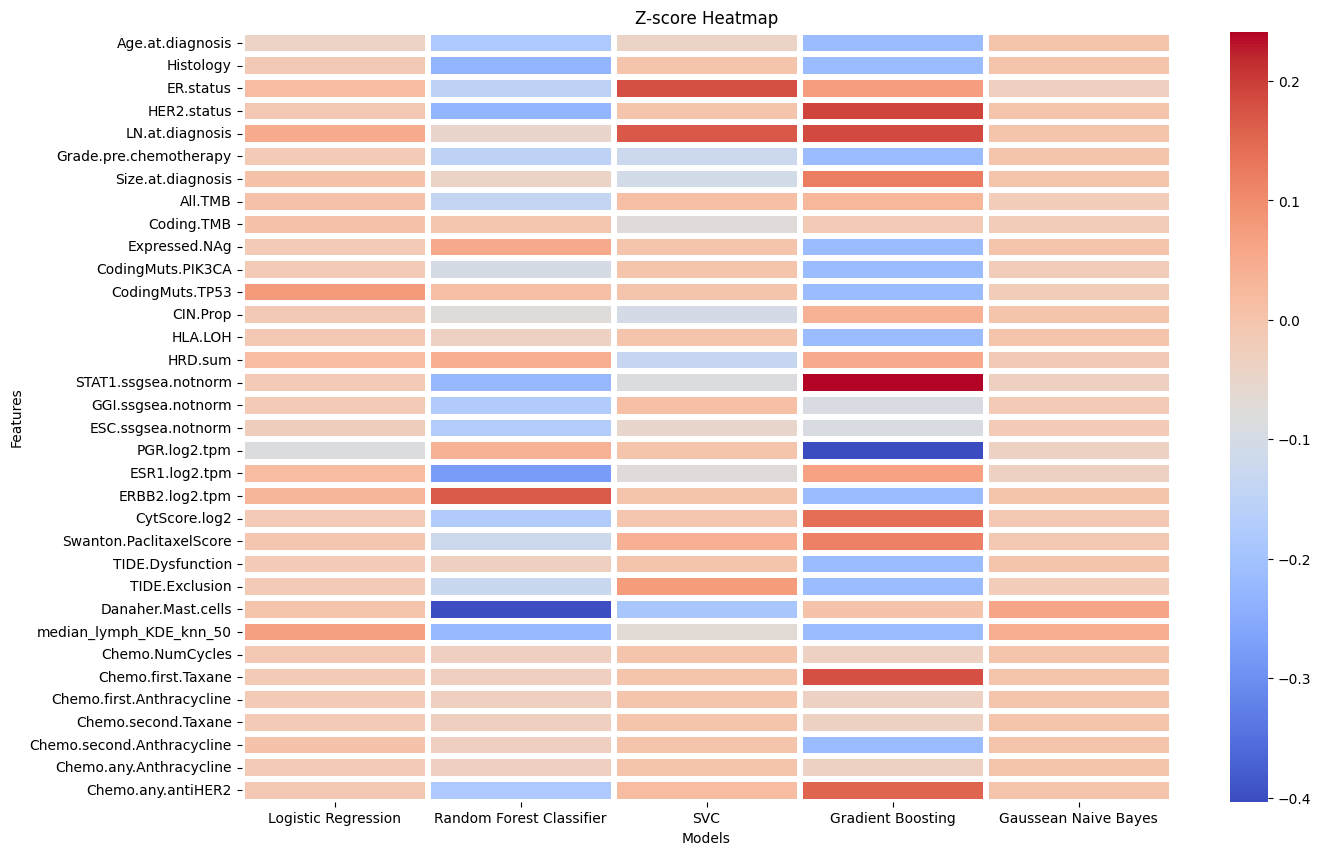

In [6]:
concatenated_df = pd.concat([feature_df1, feature_df2,feature_df3,feature_df4,feature_df5], axis=1)


fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(concatenated_df, cmap='coolwarm', annot=False, fmt=".3f", ax=ax,linewidths=3)


ax.set_xlabel("Models")
ax.set_ylabel("Features")
ax.set_title("Z-score Heatmap")

plt.savefig('images/EDfig9b', bbox_inches='tight', transparent=False, dpi=300)

plt.show()

## Fig 4 B


In [9]:

with open(z_score_dir+"/Zscore_model_logres_random_123_Date_2023_7_26_08_32_32.p",'rb') as w:
    

    feature_df1 = pickle.load(w, encoding='utf-8')
    

with open(z_score_dir+"/Zscore_model_rf_random_123_Date_2023_7_26_08_59_22.p",'rb') as w:
       
    feature_df2 = pickle.load(w, encoding='utf-8')


with open(z_score_dir+"/Zscore_model_svc_random_123_Date_2023_7_26_10_28_57.p",'rb') as w:
       
    feature_df3 = pickle.load(w, encoding='utf-8')


with open(z_score_dir+"/Zscore_model_gb_random_123_Date_2023_7_26_10_57_23.p",'rb') as w:
       
    feature_df4 = pickle.load(w, encoding='utf-8')


with open(z_score_dir+"/Zscore_model_nb_random_123_Date_2023_7_26_11_00_27.p",'rb') as w:
       
    feature_df5 = pickle.load(w, encoding='utf-8')


average_df = (feature_df1+feature_df2+feature_df3+feature_df4+feature_df5)/5


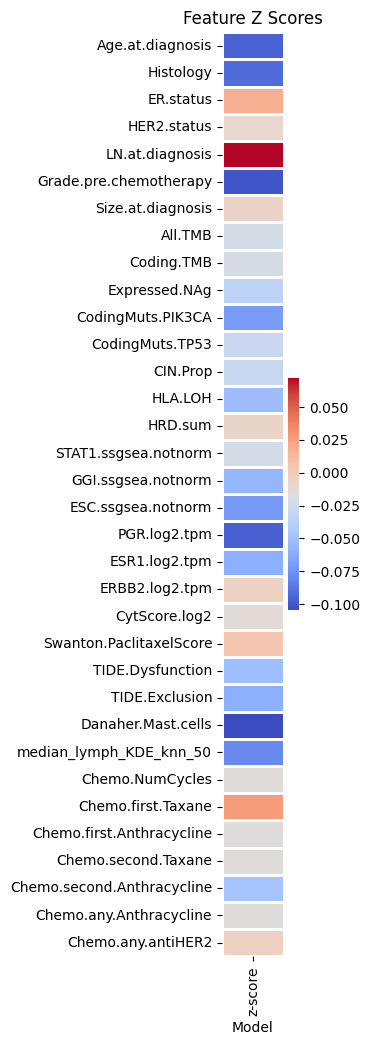

In [10]:
plt.figure(figsize=(1, 12))

sns.heatmap(average_df[['z-score']], cmap='coolwarm', annot=False, fmt='.2f', linewidths=2)
plt.xlabel('Model')
plt.title('Feature Z Scores')
plt.xticks(rotation=90)
plt.show()

## ED Fig 9 a coorlation map

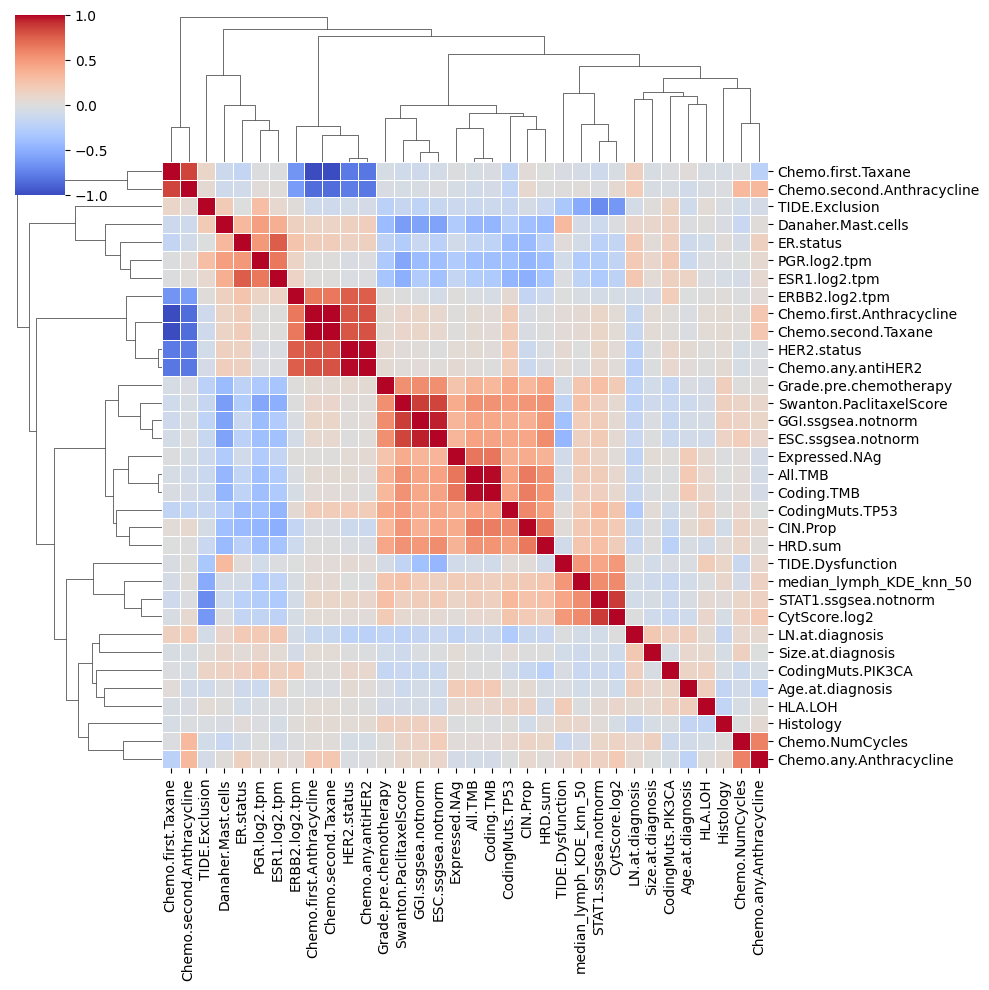

In [7]:
unique_feats = defineFeatures('chemo',her2=her2)

corr = df_train[unique_feats].corr(method='spearman')

sns.clustermap(corr,cmap ='coolwarm' ,linewidths=.5,annot = False)
plt.savefig('images/EDfig9a', bbox_inches='tight', transparent=False, dpi=300)
plt.show()

## ROC Curves

c:\Users\luejay\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luejay\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


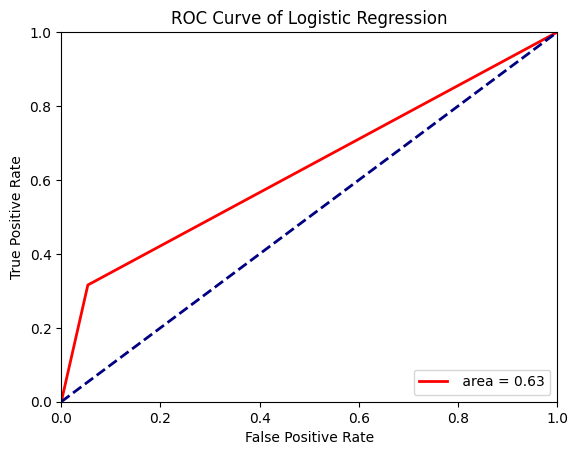

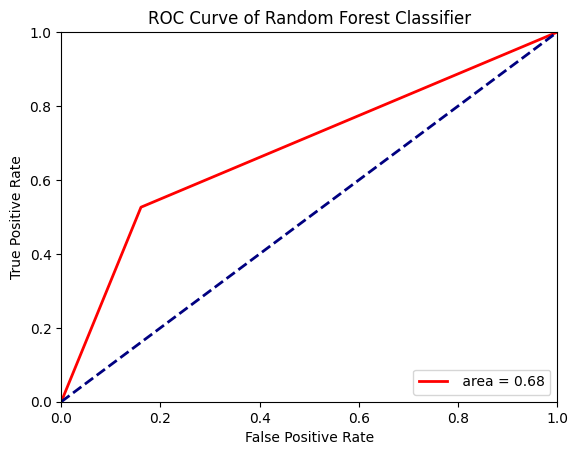

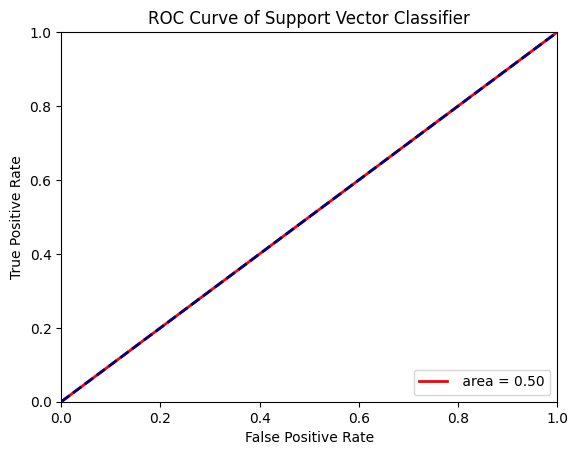

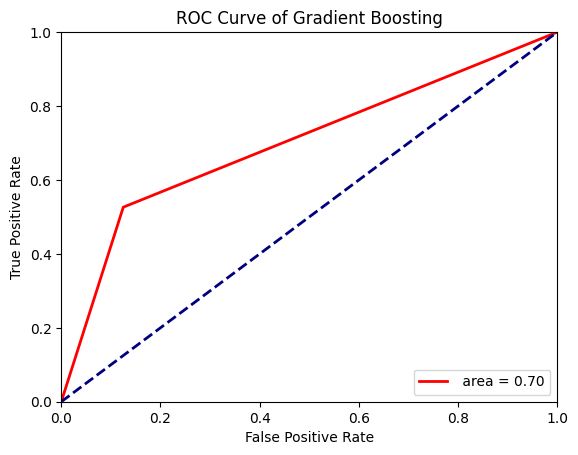

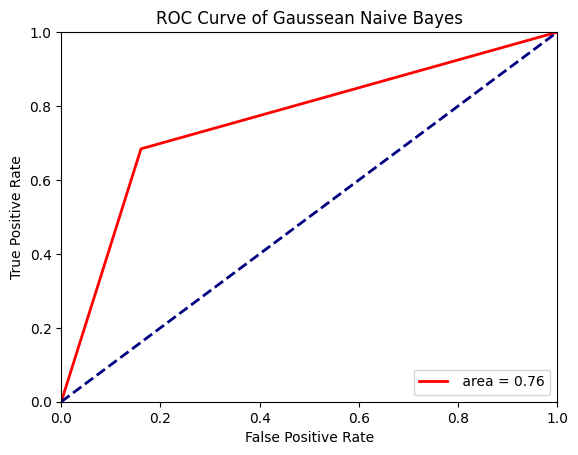

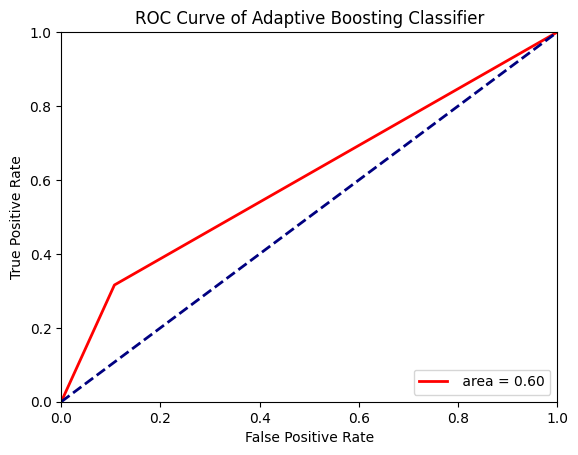

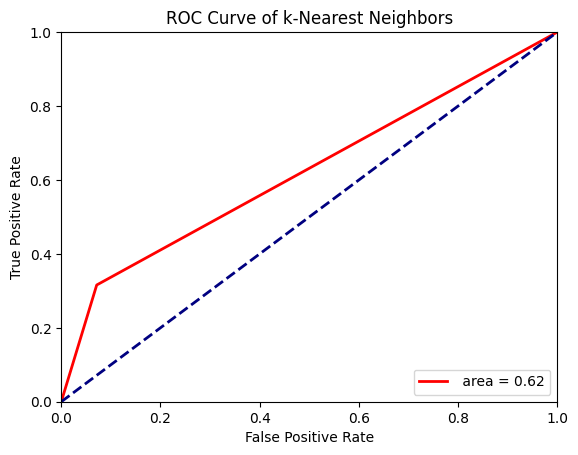

In [ ]:

for ind,comb_model in ml_dict.items():
    
    y_pred_pCR_pos = comb_model.predict(x_test_pCR_pos)
    y_pred_pCR_neg = comb_model.predict(x_test_pCR_neg)

    
    y_pred_comb = np.concatenate((y_pred_pCR_pos,y_pred_pCR_neg),axis = 0)
    
    fp_rate, tp_rate, thresholds = roc_curve(y_test_comb, y_pred_comb)
    
    roc_auc = auc(fp_rate, tp_rate)

    
    
   
    
    
    
    
    
    
    
    plt.figure()
    plt.plot(fp_rate, tp_rate, color='red', lw=2, label=' area = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of {}'.format(ind))
    
    
    plt.legend(loc='lower right')
    
    #plt.show()
